# ***Cart***

In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import os
import random
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import lime.lime_tabular
import time

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()
from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# FILE PATHS
model_filename = "../Models/best_decision_tree_model.pkl"
study_filename = "../Study/optuna_study_DT_nested.pkl"
metrics_filename = "../Models/best_decision_tree_metrics.pkl"
fold_metrics_filename = "./Metrics/cart_folds_summary.csv"

In [4]:
# PIPELINE BUILDER
def build_pipeline(params: dict) -> Pipeline:
    """
    Creates a pipeline with preprocessing and a DecisionTreeClassifier.
    """
    preprocessor = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])
    model = DecisionTreeClassifier(**params, random_state=SEED, class_weight="balanced")
    return Pipeline([('preprocessor', preprocessor), ('classifier', model)])

In [5]:
# HYPERPARAMETER TUNING
def run_inner_optuna(X_inner: pd.DataFrame, y_inner: pd.Series, n_trials: int = 50) -> tuple:
    """
    Inner CV loop using Optuna to optimize DecisionTree hyperparameters.
    """
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3,10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 2, 3]),
            "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 10, 50)
        }
        pipeline = build_pipeline(params)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            pipeline.fit(X_t, y_t)
            y_pred = pipeline.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [6]:
def nested_cv(X: pd.DataFrame, y: pd.Series) -> tuple:
    """
    Executes nested CV with full metric tracking (train/val/test), including classification reports,
    confusion matrices and predict_proba for LIME. Also includes Optuna visualizations.
    """
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total=outer_cv.get_n_splits(),
        desc="Training folds"
    ):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Extra validation split for reporting
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold,
            test_size=0.2,
            stratify=y_train_fold,
            random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr)
        optuna_time = time.time() - start_time
        optuna_studies.append(study)
        model = build_pipeline(best_params)
        model.fit(X_tr, y_tr)

        # FULL train evaluation
        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)

        # Validation evaluation
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)

        # Outer test evaluation
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": optuna_time
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": model.named_steps['classifier'].classes_,
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({'studies': optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    # Visualizations for best study
    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)
    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [7]:
# Run pipeline
model, metrics, study, visualizations = nested_cv(X, y)

In [8]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['GRUPO', 'Cupo',
                                                   'dias_mora_Asignacion',
                                                   'saldo_total',
                                                   'Mora_maxima_cliente__Asignacion',
                                                   'situacion', 'Vencto',
                                                   'Priorizacion',
                                                   'Priorizacion_mes_anterior',
                                                   'CONTEO_PRODUCTOS',
                                                   'CAPITAL', 'EDAD',
                                                   'DiasUltimaGestion',
                                                   'DiasMejorGestion',
                                                   'HabitoPago11',
                                                   'Habi...
                                                   'Oficina', 'Tipo_Linea_1',
                                                   'Arquetipos',
                                                   'Ultimo_Canal_Gestion',
                                                   'CR_Ultima_Gestion_Cliente',
                                                   'CR_Mejor_Gestion_Cliente',
                                                   'NumeroCuotas'])])),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.0018726319923070764,
                                        class_weight='balanced',
                                        criterion='entropy', max_depth=6,
                                        max_features='log2', max_leaf_nodes=21,
                                        min_samples_leaf=16,
                                        min_samples_split=8,
                                        random_state=42))])

In [9]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      3426
           1       0.56      0.62      0.59      1034
           2       0.52      0.51      0.52       625

    accuracy                           0.75      5085
   macro avg       0.65      0.66      0.65      5085
weighted avg       0.76      0.75      0.76      5085



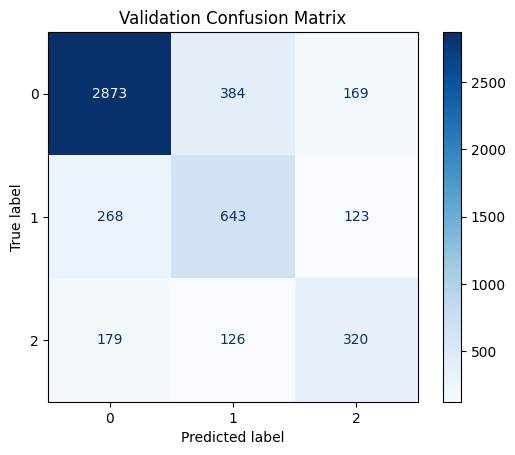

In [10]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [11]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4282
           1       0.57      0.61      0.59      1293
           2       0.51      0.51      0.51       781

    accuracy                           0.76      6356
   macro avg       0.65      0.66      0.65      6356
weighted avg       0.76      0.76      0.76      6356



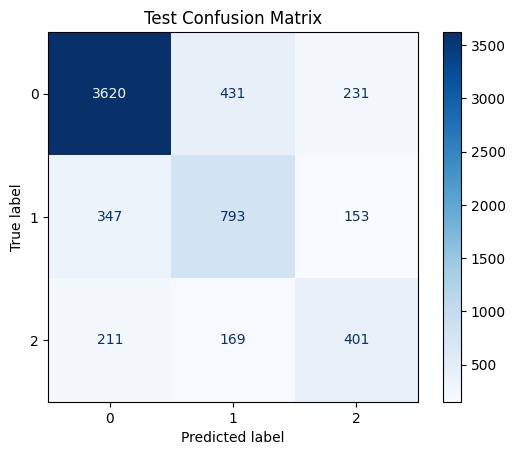

In [12]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

--- Explanation for class 0 ---


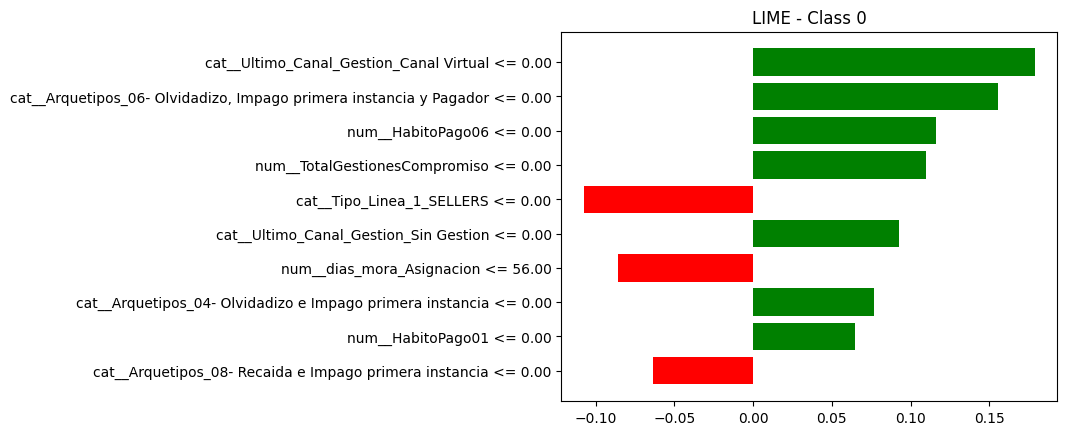

--- Explanation for class 1 ---


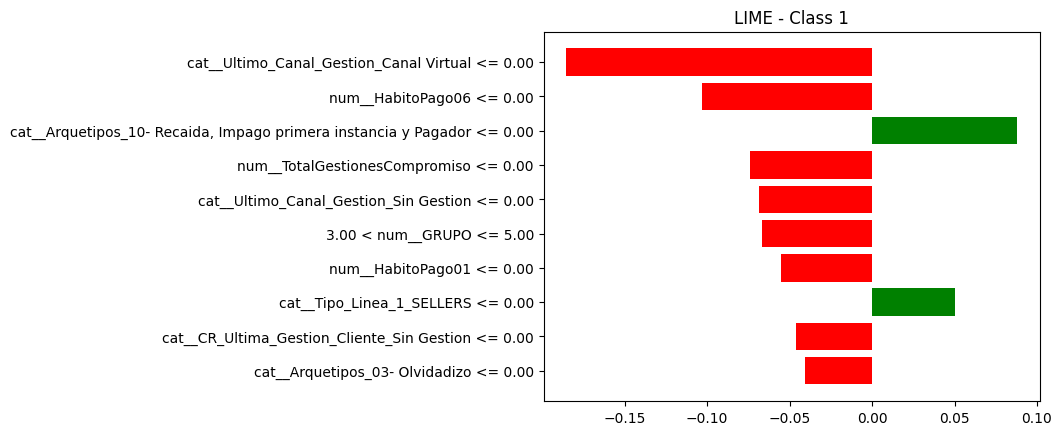

--- Explanation for class 2 ---


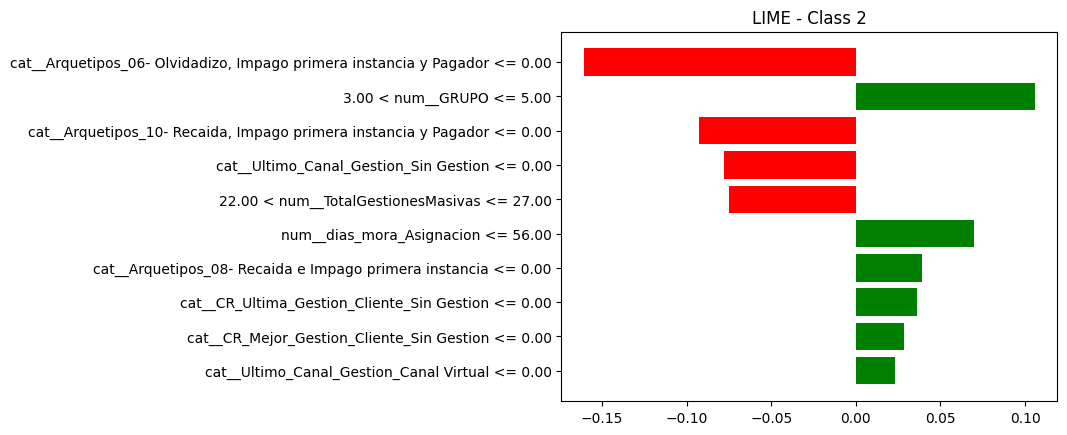

In [13]:
# Get LIME explainer and transformed data
explainer, X_transformed = me.get_lime_explainer(model, metrics['X_train_fold'], metrics['y_train_fold'])

clf = model.named_steps['classifier']
predict_fn = lambda x: clf.predict_proba(x)
instance = X_transformed[10]
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])
exp.show_in_notebook(show_table=True)

# Plot per-class explanations
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()

In [14]:
visualizations['optimization_history']

In [15]:
visualizations['parallel_coordinate']

In [16]:
visualizations['f1_score_evolution']

In [17]:
visualizations['param_importances']

In [18]:
# Feature Importance Plot
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

fig = px.bar(importance_df,
             x='Feature',
             y='Importance',
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',
             color_continuous_scale='Viridis',
             text='Importance')
fig.update_layout(xaxis_tickangle=45)
fig.show()

In [19]:
reporte.save(metrics, model_name="CART")


Report for model 'CART' saved:
   → CSV: ./Metrics/Metrics_CART.csv
   → JSON: ./Metrics/Metrics_CART.json


In [20]:
df = reporte.load()


Loaded 8 report(s)


In [21]:
df.query("Model == 'CART' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
78,CART,val,0,0.865,0.839,0.852
79,CART,val,1,0.558,0.622,0.588
80,CART,val,2,0.523,0.512,0.517
81,CART,val,macro avg,0.649,0.657,0.652
82,CART,val,weighted avg,0.761,0.754,0.757


In [22]:
df.query("Model == 'CART' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
84,CART,test,0,0.866,0.845,0.856
85,CART,test,1,0.569,0.613,0.59
86,CART,test,2,0.511,0.513,0.512
87,CART,test,macro avg,0.649,0.657,0.653
88,CART,test,weighted avg,0.762,0.757,0.76


In [ ]:
df.query("Model == 'CART' and auc != '-' and Type != 'train'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
77,CART,train,0.76,0.73,0.85
83,CART,val,0.754,0.752,0.843
89,CART,test,0.757,0.734,0.846


In [24]:
df.query("Model == 'CART' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
83,CART,val,0.754,0.752,0.843


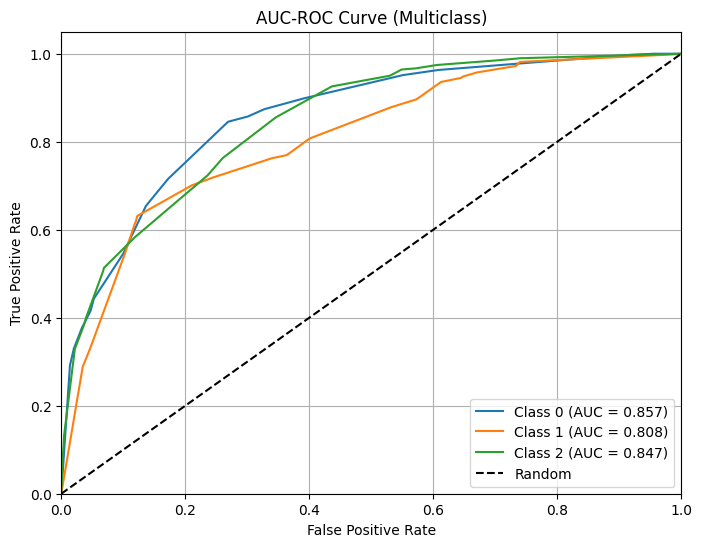

In [ ]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
)

In [26]:
model.named_steps["classifier"].get_params()

{'ccp_alpha': 0.0018726319923070764,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'log2',
 'max_leaf_nodes': 21,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}